In [1]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset'

img_size = (224, 224)
batch_size = 32

def load_and_preprocess_data(subdir_name):
    images = []
    labels = []
    
    class_counts = {}

    class_folders = os.listdir(os.path.join(data_dir, subdir_name))
    num_classes = len(class_folders)

    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, subdir_name, class_folder)
        num_samples = len(os.listdir(class_path))
        class_counts[class_folder] = num_samples

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array /= 255.0
            images.append(img_array)
            labels.append(class_index)
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)

    print("Class Representation:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} samples")

    return images, labels, num_classes

In [3]:
images, labels, num_classes = load_and_preprocess_data('train')
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_accuracy",patience  = 5,verbose=1,min_delta = 0.01,restore_best_weights=True)

history = model.fit(
    train_images,
    train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=batch_size,
    epochs=20,
    callbacks=[early_stopping]
)


Class Representation:
Audi: 814 samples
Hyundai Creta: 271 samples
Mahindra Scorpio: 316 samples
Rolls Royce: 311 samples
Swift: 424 samples
Tata Safari: 441 samples
Toyota Innova: 775 samples
Epoch 1/20
84/84 [==============================] - 14s 61ms/step - loss: 0.8261 - accuracy: 0.7341 - val_loss: 0.4822 - val_accuracy: 0.8241
Epoch 2/20
84/84 [==============================] - 4s 45ms/step - loss: 0.3221 - accuracy: 0.8937 - val_loss: 0.5140 - val_accuracy: 0.8465
Epoch 3/20
84/84 [==============================] - 3s 42ms/step - loss: 0.1890 - accuracy: 0.9426 - val_loss: 0.4460 - val_accuracy: 0.8495
Epoch 4/20
84/84 [==============================] - 4s 43ms/step - loss: 0.1199 - accuracy: 0.9690 - val_loss: 0.3782 - val_accuracy: 0.8763
Epoch 5/20
84/84 [==============================] - 4s 42ms/step - loss: 0.0559 - accuracy: 0.9918 - val_loss: 0.4549 - val_accuracy: 0.8763
Epoch 6/20
84/84 [==============================] - 4s 42ms/step - loss: 0.0366 - accuracy: 0.9940 - 

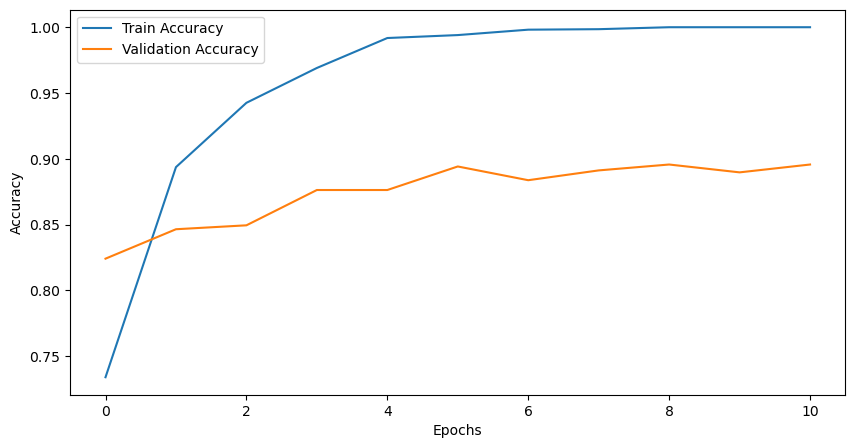

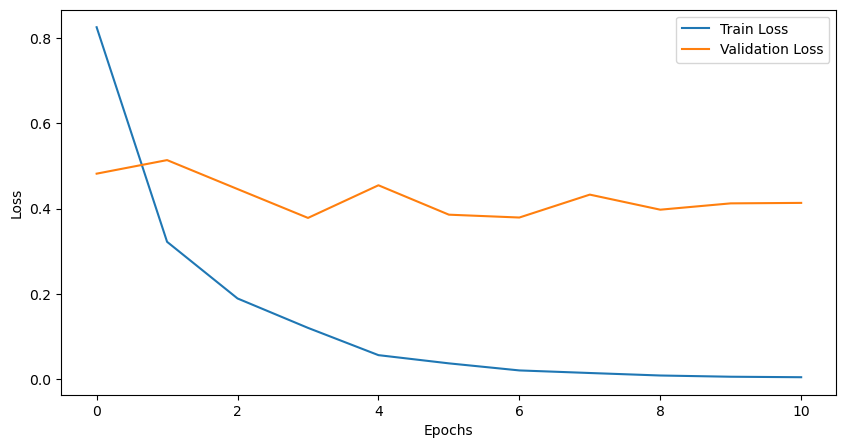

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Load the test data
test_images, test_labels, num_classes = load_and_preprocess_data('test')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test data
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
arr = confusion_matrix(true_classes, test_predictions_classes)

# Print the classification report
class_names = [str(i) for i in range(num_classes)]  # Use numeric class labels for the test dataset
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


Class Representation:
Audi: 199 samples
Hyundai Creta: 67 samples
Mahindra Scorpio: 75 samples
Rolls Royce: 74 samples
Swift: 102 samples
Tata Safari: 106 samples
Toyota Innova: 190 samples
26/26 [==============================] - 5s 186ms/step - loss: 0.3095 - accuracy: 0.9077
Test Loss: 0.3094746768474579
Test Accuracy: 0.9077490568161011
26/26 [==============================] - 2s 31ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       199
           1       0.86      0.82      0.84        67
           2       0.90      0.93      0.92        75
           3       0.89      0.76      0.82        74
           4       0.94      0.87      0.90       102
           5       0.88      0.93      0.91       106
           6       0.94      0.95      0.94       190

    accuracy                           0.91       813
   macro avg       0.90      0.89      0.89       813
weighted avg       0.91      0.91    

<AxesSubplot:>

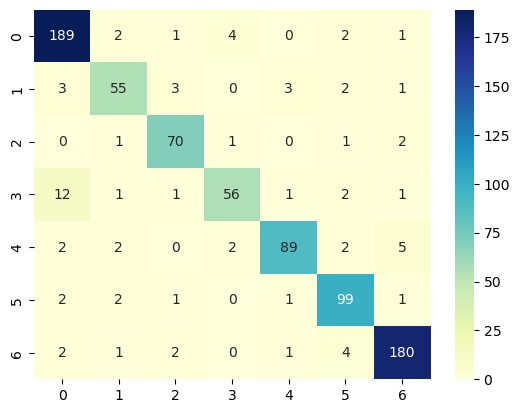

In [6]:
import seaborn as sn
df_cm = pd.DataFrame(arr, range(7), range(7))
sn.heatmap(df_cm, annot=True,fmt="d", cmap="YlGnBu") 

In [7]:
# Create a DataFrame from the classification report
classification_dict = classification_report(true_classes, test_predictions_classes, target_names=class_names, output_dict=True)
classification_df = pd.DataFrame(classification_dict).transpose()

# Save the DataFrame as an Excel file
excel_path = os.path.join(r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset', 'classification_report.xlsx')
classification_df.to_excel(excel_path, index=True)

print(f"Classification report saved as Excel to {excel_path}")

Classification report saved as Excel to C:\Users\haris\AI\ML\Projects\Data\Cars Dataset\classification_report.xlsx


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           